In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sonecules

In [25]:
%run prepare-data.ipynb


# sonecules: A Python Sonfication Architecture
### ICAD 2023 - Dennis Reinsch, Thomas Hermann - Ambient Intelligence Group, Bielefeld University

# Sonification Pipeline / Process

<center>
<img src="./figures/soni-pipeline-basic-small.jpg"/>
</center>

# Aproaches to Sonification


* two extremes

* (i) open sound synthesis platforms high-jacked for sonification

* (ii) all-in-one graphical sonification design programs

* both create a walled garden

two extrema
(i) open sound synthesis platforms high-jacked for sonification
- examples: SuperCollider, PureData, Max/MSP, Csound
- requires knowledge in regard of sound synthesis to even get started.
  something what seems strange when we relate it to visualization
- often lack data handling
(ii) complex all-in-one graphical sonifi- cation design programs: in this case complete/self-contained pack- ages are provided which often come with GUI, data import func- tions, and one (or few) very specific sonification design(s).
- examples: Highcharts Sonification Studio, Sonification Workstation, or Rotator
- Such systems are much more beginner-friendly as compared to the above class of approaches,
- large code base to integrate the implemented sonification design with specific data loading and processing capabilities and in addition provide a graphical user interface for all this.
- but they are quite limited to their specific use case as they are hard (if not impossible) to extend – or even to be adjusted in parameters, if developers did not already offer a control for it.


To our opinion, both of these extremes create some kind of walled garden which hinders the sonification community to share their methods and grow
We believe that the walls can be teared down by following the example of how computer graphics was made available to users,

# Toolchain Solution

<center>
<img src="./figures/sonification-toolchain.jpg"/>
</center>

* do one thing but do it well - UNIX principle

# Fundamental Concepts

* Context and Timeline

In [19]:
sonecules.startup()

<IPython.core.display.Javascript object>

SC already started
sclang already started
scsynth already started


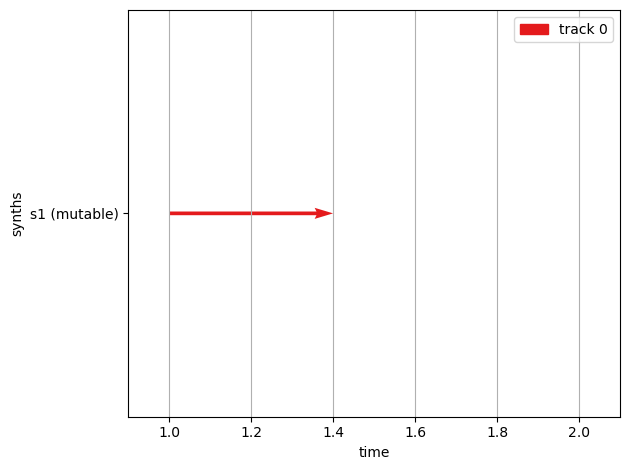

In [20]:
context = sonecules.gcc()

s1 = context.synths.create("s1")

with context.at(1):
    s1.start(freq=300)
    
context.timeline.plot()

In [ ]:
playback = sn.playback()

# Sonecules Demo


# ---


# Critical Goals

  a) flexibility and portability
  
  b) availability and distribution
  
  c) reproducibility
  
  d) benchmarking, enchancing scientific standards and development
  
  e) dissemination


# Conclusion


* design-once-use-many approach 

# ---


# Sonification Pipeline - All in One

<center>
<img src="./figures/soni-pipeline-allinone-small.jpg"/>
</center>

IN: The first example are tools that offer the user to handle the complete pipeline

However the resulting tools are often very specialized towards certain tasks and often can be regarded  as a graphical user interface for a single sonification design.

This does not allow the user to create completely new sonifications as the tools are not flexible enough, but rather use a certain sonification without much effort.


OUT: This is why many sonification experts prefer to built their own custom tools

# Sonification Pipeline - Combination of Tools

<center>
<img src="./figures/soni-pipeline-combi-small.jpg"/>
</center>

* sc3nb = Python + SuperCollder in Jupyter notebooks

IN: A common approach here is to use a sound synthesis engine like SuperCollider for creating the sound 

the data is prepared beforehand with other tools like Python.


While this approach offers the user a more flexible way it still requires the user to have knowledge about used sound synthesis engine


additionally it often becomes complicated to mix and match the different tools with each other and share the data



To tackle this problem we already created sc3nb which makes SuperCollider accessible from Python and allows the combined usage in one interactive Jupyter notebook

However sc3nb is strictly tied to SuperCollider and requires that the user is familiar with SuperCollider 


OUT: 

# mesonic

<center>
<img src="./figures/mesonic-pipeline.jpg"/>
</center>

IN: mesonic wants to go further by more directly focusing on the transformation.

this is done by providing a meso level that should be more flexible than high level (all in one) approaches 

but it should still offer the user an a shortcut to create new sonifications designs

instead of requiring the creation of custom tools, which are often hard to share and maintain

and require the user to deeply dive down into sound synthesis engines.

While at least some knowledge about sound synthesis is required to create a sonification it should be noted that the
most sound synthesis tools are quite complex and can be intimidating for new users that want create a new sonification

Additionally it is important to note that most sound synthesis engines are not specifically crafted for sonifications and often lack data processing capabilities.

OUT: The idea to introduce a layer in between the low level sound synthesis world and the high level sonification applications is inspired by the visualization domain


# matplotlib

<center>
<img src="./figures/anatomy-of-figure.jpg"/>
</center>

IN: If we look at matplotlib f.e. it becomes obvious that .. 

the plots does consists of different objects

These objects together form the complete plot 

As a user I do not need to create every single linie
but i can create complex plots by single function calls that will provide me all the single objects

Additionally it is possible to fine tune the plot using a object oriented approach.
and adjust f.e. the limits and the title.

This is what makes matplotlib easy to use but still a flexible basis for many other applications.

OUT: mesonic tries to adapt this idea to form a sonification from single parts and other ideas from the visualization domain into the domain of sonification



# mesonic - audio objects

<center>
<img src="./figures/mesonic-synth.jpg"/>
</center>

* practical use: discrete vs continuous Parameter Mapping Sonification

* inspired by Enge et al. 2021 - **0D / 1D auditory mark**

# mesonic - audio objects

<center>
<img src="./figures/mesonic-buffer-record.jpg"/>
</center>

# Example

In [43]:
import mesonic
import numpy as np
from pya import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from sc3nb import linlin, midicps, cpsmidi
import sc3nb as scn

Lets start by preparing mesonic

In [44]:
context = mesonic.create_context()
context.enable_realtime();
context.processor.latency = 0.05
context.processor.latency

<IPython.core.display.Javascript object>

SC already started
sclang already started
scsynth already started


0.05

In this example we will use the EEG data from the [Supplementary material for "sc3nb: a Python-SuperCollider Interface for Auditory Data Science"](https://doi.org/10.4119/unibi/2956379)

In [45]:
data = np.loadtxt("./files/epileptic-eeg.csv", delimiter=",")

We can simply create a stereo Buffer using this data

In [46]:
buf = context.buffers.from_data(data[:,[0,1]], sr=256)
buf

Buffer(2 x 25642 @ 256Hz = 50.082s)

And create a default Synth to play it back

In [47]:
bsyn = context.synths.from_buffer(buf)

In [48]:
bsyn # to see the synth's controls

Synth(sc3nb_playbuf_131, {'out': 0.0, 'bufnum': 131.0, 'rate': 1.0, 'loop': 0.0, 'pan': 0.0, 'amp': 0.3})

let's audify the data in a loop

In [49]:
bsyn.start(rate=20, amp=0.1, loop=1)

In [50]:
bsyn.rate = 5
bsyn.amp = 1

In [51]:
bsyn.stop()

A more advanced example using Granular Synthesis for interactive scrubbing of the buffer

In [52]:
context.synths.buffer_synthdefs["tgrains"]= r"""
{ | bufnum={{BUFNUM}}, amp=0.3, rate=10, trate=5, pos=0 |
    var dur, cpos, sig;
    dur = 4 / trate;
    cpos = pos * BufDur.kr(bufnum);
    sig = TGrains.ar(2, Impulse.ar(trate), bufnum, rate, cpos, dur, 0, 0.5, 2);
    Out.ar(0, sig * amp);
}"""

In [53]:
buf = context.buffers.from_data(data[:,5], sr=256)

In [54]:
tgsyn = context.synths.from_buffer(buf, synth_name="tgrains")
tgsyn

Synth(sc3nb_tgrains_132, {'bufnum': 132.0, 'amp': 0.3, 'rate': 10.0, 'trate': 5.0, 'pos': 0.0})

In [55]:
tgsyn.start(rate=20)

In [56]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(8,2))
asig = Asig(data[:,5], sr=256).plot()

def on_move(event):
    if event.inaxes and event.button is mpl.backend_bases.MouseButton.LEFT:
        tgsyn.rate =  20 if event.ydata > 0 else 50
        tgsyn.pos = linlin(event.xdata, 0, 50, 0, 1)

binding_id = fig.canvas.mpl_connect('motion_notify_event', on_move)

In [57]:
tgsyn.stop()

# mesonic concepts

<center>
<img src="./figures/mesonic-concepts.jpg"/>
</center>

Here you can see an overview of the concepts used in mesonic

- the Context can be regarded as counterpart of the Figure from matplotlib and as the central interface
    - it controls the backend which is clearly separated and designed to be exchangeable

- The Backend provides different Managers to create the Audio Objects
- and is also responsible for creating the Audio Object EventHandlers that will create sound in the backend 


- The Audio Objects  are the available building blocks for the sonification which are inspired by common concepts from sound synthesis software
- The different objects offer actions like f.e. starting a Synth with a certain frequency
These however do not directly generate sounds but rather create Events 

The events are then passed to the Context which
provides the sonification time for the event.
The Event then will be inserted into the timeline as a bundles 

The Timeline then forms a data structure that contains all the actions from the sonification

To actually listen to the sonification the events in the timeline can be rendered offline or by the playback

The playback offers an interactive control over the sonification and allows f.e. filtering by data source via the BundleProcessor
before passing the events to the Audio Object EventHandler in the Backend 



In [41]:
print(context.synths.buffer_synthdefs["playbuf"])


{ |out=0, bufnum={{BUFNUM}}, rate=1, loop=0, pan=0, amp=0.3 |
    var sig = PlayBuf.ar({{NUM_CHANNELS}}, bufnum,
        rate*BufRateScale.kr(bufnum),
        loop: loop,
        doneAction: Done.freeSelf);
    Out.ar(out, Pan2.ar(sig, pan, amp))
}


In [42]:
context.timeline.plot()